# Data preprocessing
it contains two large modules:
process X and process Y

In [1]:
import arcpy
import numpy as np
import os, glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
arcpy.CheckExtension('ImageAnalyst')

'Available'

In [3]:
arcpy.env.workspace = r'C:\Users\yuch\Downloads\thesis\DL-RockClassification\data\block1\raw_data\workspace'

## process X
### X from sentinal 2 L2A data
#### check bands and resolutions, resample all bands to 10m
resolution 10m: band2(blue), band3(green), band4(red), band8(nir)<br>
need to be resampled to R10m: band5, band6, band7, band8A, band11, band12<br>
band1, band9, band10 are useless, only for correction
so the total num of bands is 10

In [ ]:
sent_path = r'C:\Users\yuch\Downloads\thesis\data\block1\raw_data\S2B_MSIL2A_20180403T005709_N0206_R002_T54KUB_20180403T023306.SAFE\GRANULE\L2A_T54KUB_A005605_20180403T005704\IMG_DATA'

In [5]:
resample_bands = ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12']

In [26]:
# do the resample
resolution = "10 10"
for band in resample_bands:
    inpath = glob.glob(topDir+'/R20m/*_{0}_20m.jp2'.format(band))[0]
    outpath = topDir+'/R10m/T54KUB_20180403T005709_{0}_10m.jp2'.format(band)
    arcpy.Resample_management(inpath, outpath, resolution, "NEAREST")

In [106]:
# resample of other data

In [5]:
inbands = ';'.join(sorted(glob.glob(topDir+'/R10m/*_B*_10m.jp2')))

In [ ]:
# the output multiband raster will be stored in this workspace
arcpy.CompositeBands_management(in_rasters=inbands, out_raster='multibands.jp2')

#### combine with geophysical data

In [8]:
geo_path = 'C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/geophysical'

In [10]:
geo = arcpy.sa.Raster(geo_path+'/tmi.tif')

In [12]:
geo = arcpy.sa.Raster(r'D:\Data\Townsville\Mount_Isa_data\magnetics\MagGrids_LL\georgina_tmi.ers')

#### rescale the bands into 0,1

In [2]:
raster = arcpy.Raster('./data/block1/raw_data/workspace/sent_geo.tif')

In [5]:
raster_num = arcpy.RasterToNumPyArray(raster)

In [9]:
for i in range(10):
    raster_num[i,:,:] = raster_num[i,:,:]/10000.

In [12]:
for i in range(10, 23):
    raster_num[i,:,:] = (raster_num[i,:,:] - raster_num[i,:,:].min()) / (raster_num[i,:,:].max() - raster_num[i,:,:].min())

In [17]:
new_raster = arcpy.NumPyArrayToRaster(
    in_array=raster_num,
    lower_left_corner=raster.extent.lowerLeft,
    x_cell_size=raster.meanCellWidth,
    y_cell_size=raster.meanCellHeight,
)

new_raster.save('./data/block1/raw_data/workspace/sent_geo_norm.tif')

In [22]:
np.save('./data/block1/raw_data/workspace/sent_geo_norm', raster_num)

#### composite all useful bands into a multiband raster
| band | meaning |
|-------|------|
| 0     | Blue |
| 1     | Green |
| 2     | Red |
| 3     | VRE |
| 4     | VRE |
| 5     | VRE |
| 6     | NIR |
| 7     | SWIR |
| 8     | SWIR |
| 9     | VRE |
| 10    | K |
| 11    | Kpcent |
| 12    | TH |
| 13    | U |
| 14    | U2 |
| 15    | magnetic |
| 16    | U over K |
| 17    | U over TH |
| 18    | K over TH |
| 19    | K over U |
| 20    | U2 over TH |
| 21    | TH over U |
| 22    | TH over K |

#### calculate NDVI

In [3]:
work_dir = r'C:\Users\yuch\Downloads\thesis\data\block1\raw_data\workspace'

In [17]:
def calc_NDVI(raster, red_band, nir_band):
    """
    input: 
            raster: string, path to raster
            red_band: int
            nir_band: int
    output:
            ndvi: raster, ndvi
    """
    nir = arcpy.sa.Raster(raster+'/Band_{0}'.format(nir_band))
    red = arcpy.sa.Raster(raster+'/Band_{0}'.format(red_band))
    ndvi = arcpy.sa.Divide(arcpy.sa.Float(nir - red),
                           arcpy.sa.Float(nir + red))
    return ndvi

In [18]:
ndvi = calc_NDVI(work_dir+'/clip_multibands.jp2', 
                 3, 7)

In [15]:
ndvi.save(work_dir+'/ndvi.tif')

In [20]:
th = 0.3

In [27]:
rocks = arcpy.sa.Con(ndvi, 1, 0, 'VALUE <= {0}'.format(th))
rocks_mask = arcpy.sa.Con(ndvi, 1, where_clause='VALUE <= {0}'.format(th))

In [21]:
veges = arcpy.sa.Con(ndvi, 1, 0, 'VALUE > {0}'.format(th))

In [22]:
veges.save(work_dir+'/veges.tif')

In [25]:
rocks.save(work_dir+'/rocks.tif')

In [28]:
rocks_mask.save(work_dir+'/rocks_mask.tif')

#### deal with Y

In [24]:
labels = ['T', 'Breccia', 'Carbonate_sediment', 'Dolerite',
          'Feldspathic_sediment', 'Felsic_volcanic', 'Gneiss', 'Granite',
          'Graphite_sediment', 'Mafic_volcanic', 'Quartz_sediment']

In [6]:
label_dir = r'C:\Users\yuch\Downloads\thesis\data\labels_splits'

In [9]:
work_dir = r'C:\Users\yuch\Downloads\thesis\data\block1\raw_data\workspace'

In [7]:
arcpy.env.workspace = r'C:\Users\yuch\Downloads\thesis\data\block1\raw_data\workspace\labels'

In [28]:
rocks = arcpy.sa.Raster(work_dir+'/rocks_mask.tif')

In [36]:
label_layers = {'Vegetations': veges}
for label_name in labels:
    try:
        print('extracting {0}'.format(label_name))
        label_layers.update({label_name: arcpy.sa.ExtractByMask(rocks, 
                                              label_dir+'/{0}.shp'.format(label_name))})
    except :
        print('{0} is not in the current block'.format(label_name))

extracting T
extracting Breccia
Breccia is not in the current block
extracting Carbonate_sediment
extracting Dolerite
extracting Feldspathic_sediment
extracting Felsic_volcanic
extracting Gneiss
extracting Granite
extracting Graphite_sediment
Graphite_sediment is not in the current block
extracting Mafic_volcanic
extracting Quartz_sediment


#### composite all labels

In [ ]:
arcpy.CompositeBands_management(in_rasters=list(label_layers.values()), out_raster='compsite_labels.jp2')

#### layer number and rock type
| Layer | Rock |
|-------|------|
| 0     | Vegetation|
| 1     | Unkown Rocks|
| 2     | Carbonate_sediment|
| 3     | Dolerite|
| 4     | Feldspathic_sediment|
| 5     | Felsic_volcanic|
| 6     | Gneiss|
| 7     | Granite|
| 8     | Mafic_volcanic|
| 9     | Quartz_sediment|

## Export training data X, Y with tile of 256 x 256

#### split X into tiles

In [23]:
# raster_num = np.load('./data/block1/raw_data/workspace/sent_geo_norm.npy')
raster_num.shape

(23, 10980, 7137)

In [49]:
def split2Tiles(path, arr, x_size=256, y_size=256, suffix='block1'):
    xx, yy = arr.shape[1], arr.shape[2]
    x_num = int(xx/x_size)
    y_num = int(yy/y_size)
    print('split into {0} tiles'.format(x_num*y_num))
    count = 0
    for i in range(x_num):
        for j in range(y_num):
            tmp = arr[:, x_size*i: x_size*(i+1), y_size*j: y_size*(j+1)]
            np.save(path+'{0}_{1}'.format(suffix, count), tmp)
            count += 1

In [26]:
split2Tiles('./data/X/', raster_num)

In [18]:
arcpy.Clip_management("C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/sent_geo.tif", 
                      '302250 7590220 371370 7697740',
                      "C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/sent_geo_clip.tif", 
                      "#", "#", "NONE", "NO_MAINTAIN_EXTENT")

<Result 'C:\\Users\\yuch\\Downloads\\thesis\\DL-RockClassification\\data\\block1\\raw_data\\workspace\\sent_geo_clip.tif'>

In [5]:
inRaster = "C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/sent_geo_clip.tif"
out_folder = "C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/images"
in_training = "#"
image_chip_format = "TIFF"
tile_size_x = "256"
tile_size_y = "256"
stride_x="256"
stride_y="256"
output_nofeature_tiles="ONLY_TILES_WITH_FEATURES"
metadata_format="KITTI_rectangles"

# Execute 
arcpy.ia.ExportTrainingDataForDeepLearning(inRaster, out_folder, in_training, 
                                 image_chip_format,tile_size_x, tile_size_y, 
                                 stride_x, stride_y,output_nofeature_tiles, 
                                 metadata_format)

<geoprocessing server result object at 0x243c30d8b20>

#### split Y into tiles

In [29]:
# raster_num = arcpy.RasterToNumPyArray(arcpy.Raster('./data/block1/raw_data/workspace/labels/compsite_labels.jp2'))
# np.save('./data/block1/raw_data/workspace/labels/labels', raster_num)

In [30]:
split2Tiles('./data/Y/', raster_num)

In [4]:
arcpy.Clip_management("C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/labels/compsite_labels.jp2", 
                      '302250 7590220 371370 7697740',
                      "C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/labels/compsite_labels_clip.jp2", 
                      "#", "#", "NONE", "NO_MAINTAIN_EXTENT")

<Result 'C:\\Users\\yuch\\Downloads\\thesis\\DL-RockClassification\\data\\block1\\raw_data\\workspace\\labels\\compsite_labels_clip.jp2'>

In [6]:
inRaster = "C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/raw_data/workspace/labels/compsite_labels_clip.jp2"
out_folder = "C:/Users/yuch/Downloads/thesis/DL-RockClassification/data/block1/labels"
in_training = "#"
image_chip_format = "TIFF"
tile_size_x = "256"
tile_size_y = "256"
stride_x="256"
stride_y="256"
output_nofeature_tiles="ONLY_TILES_WITH_FEATURES"
metadata_format="KITTI_rectangles"

# Execute 
arcpy.ia.ExportTrainingDataForDeepLearning(inRaster, out_folder, in_training, 
                                 image_chip_format,tile_size_x, tile_size_y, 
                                 stride_x, stride_y,output_nofeature_tiles, 
                                 metadata_format)

<geoprocessing server result object at 0x243c30d8ad0>

In [32]:
idx = 8
img = np.load('./data/X/block1_{0}.npy'.format(idx))
lbl = np.load('./data/Y/block1_{0}.npy'.format(idx))

In [97]:
idx = '000000008'
img = arcpy.RasterToNumPyArray(arcpy.sa.Raster('C:/Users/yuch/Downloads/thesis/data/block1/images/images/{0}.tif'.format(idx)))
lbl = arcpy.RasterToNumPyArray(arcpy.sa.Raster('C:/Users/yuch/Downloads/thesis/data/block1/labels/images/{0}.tif'.format(idx)))

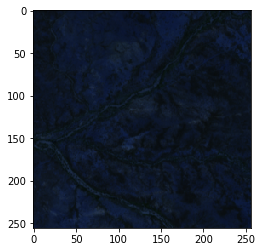

In [45]:
plt.imshow(np.transpose(img, [1,2,0])[:,:,:3])

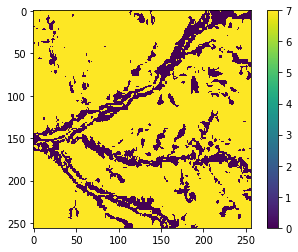

In [48]:
plt.imshow(np.argmax(lbl, axis=0))
plt.colorbar()